In [49]:
import pandas as pd
import numpy as np
import re
from pprint import pprint

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel

#spacy for lemmatization
import spacy
import en_core_web_sm
spacy.load('en_core_web_sm')

#plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

#Enable logging for gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings('ignore',category= DeprecationWarning)

In [22]:
#iniializing stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [23]:
#importing the dataset
df = pd.read_excel('PublicDomainMissionaryTexts2.xlsx')
df.head()

,Author,Book
0,Andrew Melrose,ALEXANDER MACKAY\nMISSIONARY HERO OF UGANDA\nB...
1,Anthony N. Grooves,"JOURNAL\nOF A\nRESIDENCE AT BAGDAD, \nDURING T..."
2,Charles Stanley,Printed in Hong Kong by\nTHE EMPIRE PRINTING C...
3,Clara S. Fielder,SISTER ABIGAIL\n(ABIGAIL TOWNSEND LUFFE)\nBY\n...
4,E. H. Broadbent,THE PILGRIM CHURCH\n\n\nBEING SOME ACCOUNT OF ...


In [24]:
#cleaning
#convert to list
data = df.Book.values.tolist()

In [25]:
data = [re.sub('\s+', ' ', sent) for sent in data]
data = [re.sub("\'", "", sent) for sent in data]
data = [re.sub('\[.*?\]', '', sent) for sent in data]
data = [re.sub('\w*\d\w*', '', sent) for sent in data]
data[:1]

['ALEXANDER MACKAY MISSIONARY HERO OF UGANDA BY THE AUTHOR OF ‘THE STORY OF STANLEY’ TENTH THOUSAND LONDON: THE SUNDAY SCHOOL UNION  and  Ludgate Hill, E. C. CONTENTS. CHAPTER PAGE I. A GOOD BEGINNING  II. CHOOSING HIS LIFE-WORK  III. ON AFRICAN SOIL  IV. DANGERS AND DIFFICULTIES  V. A VISIT TO LKONGE  VI. ARRIVAL AT UGANDA  VII. KING MTESA  VIII. DISAPPOINTMENT  IX. LABOUR AND RESULTS  X. STRANGE TASKS  XI. BUILDING THE ‘ELEANOR‘  XII. KING MWANGA  XIII. UGANDA. MARTYRS  XIV. GOOD-BYE TO UGANDA  XV. FRIENDS AND FELLOW-WORKERS  XVI. LAST DAYS  PREFACE TO SECOND EDITION. BY THE REV. T. C. WILSON (C. M. S. ). IT was in the early part of  that I made the acquaintance of A. M. Mackay, when, having offered for the mission to Uganda, I went up to London to meet those who were to be my fellow-missionaries in the ‘Dark Continent.’ He sailed before me to Zanzibar, but we met again there for a short time. Then I left the coast with our first caravan, and a long time was to elapse before we were 

In [27]:
#Word Tokenization
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(data))
print(data_words[:1])

[['alexander', 'mackay', 'missionary', 'hero', 'of', 'uganda', 'by', 'the', 'author', 'of', 'the', 'story', 'of', 'stanley', 'tenth', 'thousand', 'london', 'the', 'sunday', 'school', 'union', 'and', 'ludgate', 'hill', 'contents', 'chapter', 'page', 'good', 'beginning', 'ii', 'choosing', 'his', 'life', 'work', 'iii', 'on', 'african', 'soil', 'iv', 'dangers', 'and', 'difficulties', 'visit', 'to', 'lkonge', 'vi', 'arrival', 'at', 'uganda', 'vii', 'king', 'mtesa', 'viii', 'disappointment', 'ix', 'labour', 'and', 'results', 'strange', 'tasks', 'xi', 'building', 'the', 'eleanor', 'xii', 'king', 'mwanga', 'xiii', 'uganda', 'martyrs', 'xiv', 'good', 'bye', 'to', 'uganda', 'xv', 'friends', 'and', 'fellow', 'workers', 'xvi', 'last', 'days', 'preface', 'to', 'second', 'edition', 'by', 'the', 'rev', 'wilson', 'it', 'was', 'in', 'the', 'early', 'part', 'of', 'that', 'made', 'the', 'acquaintance', 'of', 'mackay', 'when', 'having', 'offered', 'for', 'the', 'mission', 'to', 'uganda', 'went', 'up', 'to

In [30]:
#build bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

#Faster way to get sentences clubbed as bigrams or trigrams
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#see trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['alexander', 'mackay', 'missionary', 'hero', 'of', 'uganda', 'by', 'the', 'author', 'of', 'the', 'story', 'of', 'stanley', 'tenth', 'thousand', 'london', 'the', 'sunday_school', 'union', 'and', 'ludgate', 'hill', 'contents_chapter', 'page', 'good', 'beginning', 'ii', 'choosing', 'his', 'life', 'work', 'iii', 'on', 'african', 'soil', 'iv', 'dangers', 'and', 'difficulties', 'visit', 'to', 'lkonge', 'vi', 'arrival', 'at', 'uganda', 'vii', 'king', 'mtesa', 'viii', 'disappointment', 'ix', 'labour', 'and', 'results', 'strange', 'tasks', 'xi', 'building', 'the', 'eleanor', 'xii', 'king', 'mwanga', 'xiii', 'uganda', 'martyrs', 'xiv', 'good', 'bye', 'to', 'uganda', 'xv', 'friends', 'and', 'fellow', 'workers', 'xvi', 'last', 'days', 'preface', 'to', 'second', 'edition', 'by', 'the', 'rev', 'wilson', 'it', 'was', 'in', 'the', 'early', 'part', 'of', 'that', 'made', 'the', 'acquaintance', 'of', 'mackay', 'when', 'having', 'offered', 'for', 'the', 'mission', 'to', 'uganda', 'went', 'up', 'to', 'lon

In [31]:
#Define function for stopwords
def remove_stopwords(texts):
    return[[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [42]:
#Call out the functions

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['missionary', 'hero', 'story', 'union', 'ludgate', 'hill', 'page', 'good', 'beginning', 'choose', 'life', 'work', 'african', 'soil', 'danger', 'difficulty', 'visit', 'arrival', 'disappointment', 'labour', 'result', 'strange', 'task', 'build', 'friend', 'worker', 'last', 'day', 'preface', 'early', 'part', 'make', 'offer', 'mission', 'go', 'meet', 'fellow', 'missionary', 'continent', 'sail', 'meet', 'short', 'time', 'leave', 'first', 'long', 'time', 'see', 'year', 'pass', 'murder', 'summer', 'nearly', 'year', 'alone', 'hear', 'store', 'southern', 'end', 'native', 'allow', 'month', 'canoe', 'evening', 'point', 'come', 'sight', 'man', 'wanted', 'stop', 'night', 'far', 'get', 'dark', 'know', 'bay', 'overcame', 'scruple', 'take', 'paddle', 'guide', 'canoe', 'pitch', 'reach', 'place', 'fire', 'shot', 'recognise', 'signal', 'announce', 'arrival', 'turn', 'canoe', 'landward', 'soon', 'ground', 'beach', 'ashore', 'ask', 'man', 'meet', 'come', 'coast', 'white', 'man', 'come', 'minute', 'grasp',

In [44]:
#Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

#create corpus
texts = data_lemmatized

#DTM
corpus = [id2word.doc2bow(text) for text in texts]

# print(corpus[:1])

In [45]:
#Building the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus= corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [46]:
#print the keywords in 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.000*"make" + 0.000*"go" + 0.000*"come" + 0.000*"time" + 0.000*"say" + '
  '0.000*"would" + 0.000*"give" + 0.000*"take" + 0.000*"year" + 0.000*"life"'),
 (1,
  '0.001*"make" + 0.001*"go" + 0.001*"say" + 0.001*"time" + 0.001*"man" + '
  '0.001*"would" + 0.001*"come" + 0.000*"know" + 0.000*"may" + 0.000*"find"'),
 (2,
  '0.001*"go" + 0.001*"say" + 0.001*"make" + 0.001*"would" + 0.001*"work" + '
  '0.000*"take" + 0.000*"day" + 0.000*"come" + 0.000*"time" + 0.000*"man"'),
 (3,
  '0.001*"say" + 0.000*"would" + 0.000*"come" + 0.000*"make" + 0.000*"day" + '
  '0.000*"go" + 0.000*"time" + 0.000*"man" + 0.000*"take" + 0.000*"work"'),
 (4,
  '0.021*"dog" + 0.019*"camp" + 0.012*"home" + 0.012*"day" + 0.011*"horse" + '
  '0.011*"make" + 0.010*"night" + 0.010*"fire" + 0.009*"sled" + 0.009*"meat"'),
 (5,
  '0.000*"come" + 0.000*"work" + 0.000*"would" + 0.000*"take" + 0.000*"man" + '
  '0.000*"time" + 0.000*"day" + 0.000*"say" + 0.000*"go" + 0.000*"make"'),
 (6,
  '0.035*"church" + 0.018*"hi

In [50]:
# Compute the Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3002390435746024


In [51]:
#Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17     0.162722  0.024458       1        1  53.122608
8      0.175232  0.033053       2        1  13.741432
12     0.103270 -0.052841       3        1   7.967192
7      0.175365 -0.017859       4        1   7.794822
18     0.196065  0.047903       5        1   5.534751
6      0.058228  0.135062       6        1   5.451675
4      0.040514 -0.273226       7        1   5.185444
14    -0.073034  0.056081       8        1   1.190402
15    -0.051995  0.005751       9        1   0.001042
9     -0.065712  0.003169      10        1   0.000967
11    -0.065232  0.004618      11        1   0.000967
1     -0.069145  0.004238      12        1   0.000967
10    -0.069096  0.003418      13        1   0.000967
2     -0.070965  0.002359      14        1   0.000966
19    -0.071898  0.004503      15        1   0.000966
3     -0.072891  0.003638      16        1   0.000966
5     -0.074664  0.003837      17        1   0.000966
16    -0.074073  0.003984      18        1   0.000966
13    -0.075730  0.004387      19        1   0.000966
0     -0.076962  0.003466      20        1   0.000966, topic_info=    Category        Freq        Term       Total  loglift  logprob
748  Default  253.000000         say  253.000000  30.0000  30.0000
383  Default  248.000000          go  248.000000  29.0000  29.0000
983  Default  217.000000       would  217.000000  28.0000  28.0000
497  Default  119.000000        life  119.000000  27.0000  27.0000
161  Default  203.000000        come  203.000000  26.0000  26.0000
..       ...         ...         ...         ...      ...      ...
556  Topic20    0.000072  missionary   51.854580  -1.9355  -8.2006
500  Topic20    0.000075      little  103.598923  -2.5928  -8.1659
95   Topic20    0.000072        book   62.459743  -2.1271  -8.2062
187  Topic20    0.000072       could  123.920067  -2.8041  -8.1980
341  Topic20    0.000072       first  103.434624  -2.6255  -8.2002

[1421 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1941      5  0.977554    abbie
1942      5  0.958768  abigail
4039      8  1.102547   abrupt
11        1  0.596162  account
11        2  0.140273  account
...     ...       ...      ...
987       5  0.033743    young
987       6  0.033743    young
987       8  0.016871    young
3831      3  0.720688    youth
3831      8  0.240229    youth

[1225 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 9, 13, 8, 19, 7, 5, 15, 16, 10, 12, 2, 11, 3, 20, 4, 6, 17, 14, 1])

In [59]:
#Lets build the lda mallet model to improve on our lda model
mallet_path = 'mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [60]:
#show topics of updated mallet model
pprint(ldamallet.show_topics(formatted= False))


# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(3,
  [('day', 0.06353591160220995),
   ('make', 0.03959484346224678),
   ('run', 0.02394106813996317),
   ('night', 0.019337016574585635),
   ('foot', 0.019337016574585635),
   ('stand', 0.01841620626151013),
   ('head', 0.016574585635359115),
   ('back', 0.016574585635359115),
   ('experience', 0.01565377532228361),
   ('fall', 0.01565377532228361)]),
 (1,
  [('church', 0.1054739652870494),
   ('history', 0.056074766355140186),
   ('book', 0.022696929238985315),
   ('give', 0.020026702269692925),
   ('chapter', 0.017356475300400534),
   ('work', 0.01602136181575434),
   ('die', 0.014686248331108143),
   ('scripture', 0.014686248331108143),
   ('character', 0.014686248331108143),
   ('translate', 0.01335113484646195)]),
 (12,
  [('country', 0.03923444976076555),
   ('young', 0.03636363636363636),
   ('write', 0.03444976076555024),
   ('friend', 0.031578947368421054),
   ('father', 0.02200956937799043),
   ('read', 0.021052631578947368),
   ('learn', 0.01818181818181818),
   ('family'

In [ ]:
#Coherence score got updated to 0.39 for 0.34

In [61]:
#Finding optimal number of topics from LDA

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [62]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

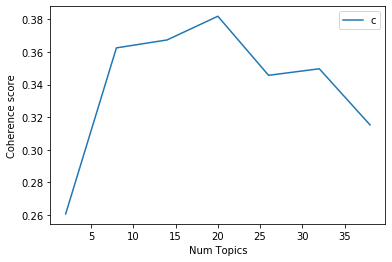

In [63]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Number of topics as 20 gives us the highest coherence score hence we will stick with it

In [64]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.046*"great" + 0.038*"time" + 0.034*"life" + 0.029*"call" + 0.025*"love" + '
  '0.025*"live" + 0.023*"long" + 0.023*"thing" + 0.021*"meeting" + '
  '0.019*"heart"'),
 (1,
  '0.049*"man" + 0.031*"pray" + 0.030*"soul" + 0.028*"joy" + 0.027*"convert" + '
  '0.023*"love" + 0.022*"truth" + 0.021*"seek" + 0.020*"hear" + 0.019*"night"'),
 (2,
  '0.029*"man" + 0.026*"run" + 0.024*"match" + 0.024*"make" + 0.021*"cricket" '
  '+ 0.021*"thing" + 0.018*"impression" + 0.018*"play" + 0.017*"studd" + '
  '0.017*"wicket"'),
 (3,
  '0.046*"man" + 0.039*"leave" + 0.033*"travel" + 0.031*"return" + '
  '0.022*"experience" + 0.021*"month" + 0.021*"foot" + 0.020*"early" + '
  '0.019*"open" + 0.017*"interest"'),
 (4,
  '0.051*"home" + 0.050*"make" + 0.045*"night" + 0.026*"start" + 0.023*"fire" '
  '+ 0.022*"mile" + 0.019*"chief" + 0.017*"big" + 0.017*"find" + '
  '0.016*"large"'),
 (5,
  '0.045*"work" + 0.032*"missionary" + 0.032*"man" + 0.023*"mackay" + '
  '0.020*"write" + 0.018*"mission" + 0.017*

In [65]:
#Lets find the dominant topic in each sentence

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.3008,"work, missionary, man, mackay, write, mission,...",ALEXANDER MACKAY MISSIONARY HERO OF UGANDA BY ...
1,1,18.0,0.3448,"place, present, thing, river, receive, church,...","JOURNAL OF A RESIDENCE AT BAGDAD, DURING THE Y..."
2,2,19.0,0.3943,"preach, word, feel, find, meet, read, work, he...",Printed in Hong Kong by THE EMPIRE PRINTING CO...
3,3,14.0,0.3944,"mother, child, dear, prayer, work, home, run, ...",SISTER ABIGAIL (ABIGAIL TOWNSEND LUFFE) BY CLA...
4,4,9.0,0.4625,"church, history, chapter, die, translate, spre...",THE PILGRIM CHURCH BEING SOME ACCOUNT OF THE C...
5,5,17.0,0.2395,"arnot, reach, part, occasion, native, letter, ...",THE LIFE & EXPLORATIONS OF FREDERICK STANLEY A...
6,6,1.0,0.3256,"man, pray, soul, joy, convert, love, truth, se...","THE KING’S SON; OR, A MEMOIR OF BILLY BRAY. TH..."
7,7,13.0,0.2858,"soldier, year, remember, car, sign, american, ...",Dedicated to the memory of General George S. B...
8,8,7.0,0.3571,"write, make, country, young, book, friend, sch...",A SKETCH OF THE LIFE OF REV. JOSEPH HARDY NEES...
9,9,10.0,0.2265,"life, young, light, land, story, build, witnes...",DAN CRAWFORD OF LUANZA Missionary Pioneers Who...


In [66]:
#Find most representative document for each topic

sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,1.0,0.3256,"man, pray, soul, joy, convert, love, truth, se...","THE KING’S SON; OR, A MEMOIR OF BILLY BRAY. TH..."
1,2.0,0.4163,"man, run, match, make, cricket, thing, impress...",C. T. STUDD CRICKETER & PIONEER By NORMAN P. G...
2,5.0,0.3008,"work, missionary, man, mackay, write, mission,...",ALEXANDER MACKAY MISSIONARY HERO OF UGANDA BY ...
3,6.0,0.3119,"bring, poor, hear, labour, village, gospel, po...","RECOLLECTIONS OF AN EVANGELIST; or, INCIDENTS ..."
4,7.0,0.3571,"write, make, country, young, book, friend, sch...",A SKETCH OF THE LIFE OF REV. JOSEPH HARDY NEES...


In [67]:
# Topic distribution across documents

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,5.0,"work, missionary, man, mackay, write, mission,...",NaN,NaN
1.0,18.0,"place, present, thing, river, receive, church,...",1.0,0.0769
2.0,19.0,"preach, word, feel, find, meet, read, work, he...",1.0,0.0769
3.0,14.0,"mother, child, dear, prayer, work, home, run, ...",NaN,NaN
4.0,9.0,"church, history, chapter, die, translate, spre...",NaN,NaN
5.0,17.0,"arnot, reach, part, occasion, native, letter, ...",1.0,0.0769
6.0,1.0,"man, pray, soul, joy, convert, love, truth, se...",1.0,0.0769
7.0,13.0,"soldier, year, remember, car, sign, american, ...",1.0,0.0769
8.0,7.0,"write, make, country, young, book, friend, sch...",NaN,NaN
9.0,10.0,"life, young, light, land, story, build, witnes...",1.0,0.0769
